In [ ]:
# title:   Coding Example - Blended Ensemble Modeling
# author:  Peter Scarbrough
# date:    30 Jan 2020
# purpose: Show example of how to use ensemble and blended models

## Introduction

Previous use of the housing data produced a random forest regressor model with an R2 of around 0.8. While this is a decent improvement over more naive method, this exercise will attempt to use a more sophisticated modeling strategy to improve upon the prior model performance. Here, I will be using stochastic gradient boosted modeling.

This will be similar to a random forest regression tree model, except successive iterations on the modeling residuals should result in a better fit of more hard-to-model regions of the original data. I will be using the stochastic variant of this gradient boosted method to try to further reduce model variation while speeding performance on my laptop.

In [1]:
# 1. Load Required Modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing   import LabelBinarizer
from sklearn.preprocessing   import StandardScaler
from sklearn.impute          import SimpleImputer
from sklearn.linear_model    import LinearRegression
from sklearn.ensemble        import RandomForestRegressor
from sklearn.ensemble        import GradientBoostingRegressor
from sklearn.svm             import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.base            import BaseEstimator
from sklearn.base            import TransformerMixin
from sklearn.pipeline        import Pipeline
from sklearn.pipeline        import FeatureUnion
from xgboost                 import XGBRegressor

In [2]:
# 2. Load Data

# define global variables
FILENAME   = "housing"
URL        = "https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/"
LOCAL_PATH = "datasets/"

# define downloading/loading functions
def download_housing_data(url=URL, local_path=LOCAL_PATH, filename=FILENAME):
    if not os.path.isdir(local_path):
        os.makedirs(local_path)
    urllib.request.urlretrieve(url + filename + ".tgz", local_path + filename + ".tgz")
    tgzfile = tarfile.open(local_path + filename + ".tgz")
    tgzfile.extractall(path=local_path)
    tgzfile.close()
    
def load_housing_data(local_path=LOCAL_PATH, filename=FILENAME):
    return(pd.read_csv(local_path+filename+".csv"))

# download and load data
# download_housing_data()
data = load_housing_data()   

Data Structure and Types:
longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object
(20640, 10)

Missingness: 
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

Category Frequency: Ocean Proximity:
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024D2A294788>,
      dtype=object)

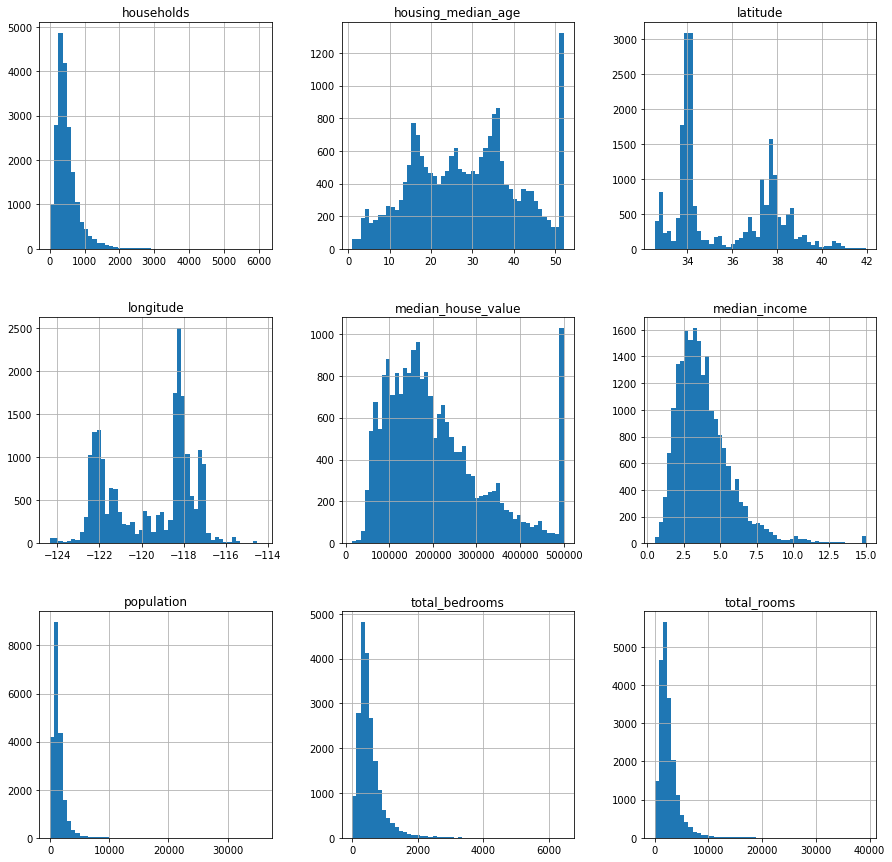

In [3]:
# 3. Brief Exploratory Data Analysis

# for jupyter notebook plotting
%matplotlib inline

def printn(*args):
    print(*args, sep="\n", end="\n\n")
    return(None)

# get data strcuture/types
printn("Data Structure and Types:",
       data.dtypes,
       data.shape)

# table of missingness
printn("Missingness: ",
       data.isnull().sum())

# table of cateogorical vars
printn("Category Frequency: Ocean Proximity:",
      data["ocean_proximity"].value_counts())

# histogram of data
data.hist(bins=50, figsize=(15,15))

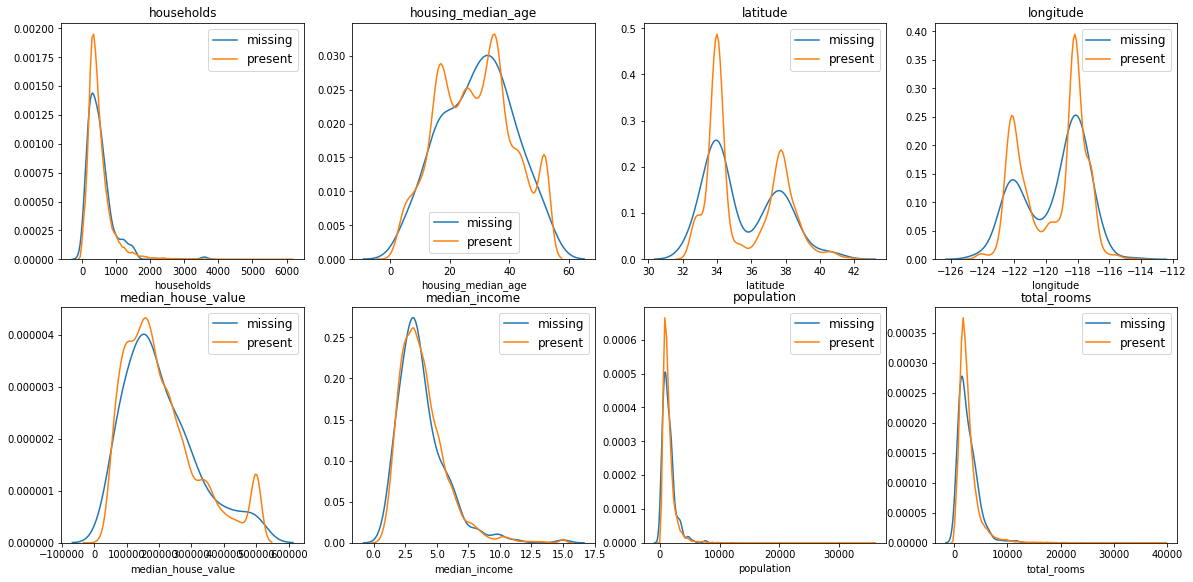

In [4]:
# Assess total bedroom missingness to find imputation strategy

# define function to plot distributions by missingness of indicated variable
def plot_miss_density(data, miss_col, nrow=4, ncol=4):
    fig       = plt.figure(figsize=(20,20))
    num_cols  = data.select_dtypes([np.number]).columns
    valid_col = num_cols.difference(np.array([miss_col]))
    for i, col in enumerate(valid_col):
        if col == miss_col:  ## don't make histogram of missingness column vs missingness of that col
            continue
        axis = fig.add_subplot(nrow,ncol,i+1)
        sns.distplot(data[data[miss_col].isnull()][col], hist=False, label="missing")
        sns.distplot(data[data[miss_col].notnull()][col], hist=False, label="present")
        axis.set_title(col)
        plt.legend(prop={"size":12})
    plt.show()

# plot densities of continuous variables by indicated missingness variable
plot_miss_density(data, "total_bedrooms")

## *Based off exploratory data analysis* 

<u>Perform required steps</u>:  

## Data Cleaning

* Split into test/training subsets (20/80) split
* Delete capped obsercations on 'median_house_value', 'housing_median_age'  
* Delete 'ocean_proximity' cases with low category counts

## Data Transformation

* log transform: 'households', 'population', total_bedrooms', 'total_rooms'
* scale all continuous variables -- mean=0, sd=1
* continuous variables -- impute missing values as median (note: distributions seem equivalent +/- missing)
* binary encode category variable

## Modeling

* use training data - split into 2 subsets (to generate predictors to build stacking model)
* create single layer stacking model  
  - random forest
  - xgboost
  - svm
* fit second subset of training data to generate blended model
* use test data - estimate blended model performance/generalizability

In [5]:
# 3. split into training and test cases (80/20 split)

data_train, data_test = train_test_split(data, train_size=0.8, random_state=123)

In [6]:
# 4. Data Cleaning

# define function to clean data, spit out X and y subsets

# a. splits data (or subset of data) into X (predictor) and y (response) subsets
def split_data(data):
    y_label  = np.array(["median_house_value"])
    x_labels = data.columns.difference(y_label)
    X = data[x_labels].copy()
    y = data[y_label].copy() 
    return(X, y)

# b. performs required cleaning operations on data (or subset) of data
def clean_data(data):
    # remove capped cases
    data_mod = data.query("median_house_value != 500001.0")
    data_mod = data_mod.query("housing_median_age != 52.0")
    
    # remove low cateogry count (ocean proximity == ISLAND (5 cts))
    data_mod = data_mod.query("ocean_proximity != 'ISLAND'")
    
    # return cleaned X, y subsets
    X, y = split_data(data_mod)
    return(X, y)

# clean data, split into subsets
X_train, y_train = clean_data(data_train) 
X_test, y_test   = clean_data(data_test)

In [7]:
# 5. define data transformation functions and pipeline

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, col_names):
        self.col_names = col_names
    def fit(self, X, y=None):
        return(self)
    def transform(self, X):
        return(X[self.col_names].values)

class Logger(BaseEstimator, TransformerMixin):
    def __init__(self, log_offset=1e-07):
        self.log_offset = log_offset
    def fit(self, X, y=None):
        return(self)
    def transform(self, X):
        return(np.log(X + self.log_offset))
    
class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

# define columns from data
# purpose: this will determine which goes in which transformation pipeline
cat_col = np.array(["ocean_proximity"])
log_col = np.array(["households", 
                    "population", 
                    "total_bedrooms", 
                    "total_rooms"])
cont_col = X_train.columns.difference(log_col).difference(cat_col)

# define transformation pipeline by category type
cat_pipeline = Pipeline((
    ("selector", DataFrameSelector(cat_col)),
    ("binarizer", MyLabelBinarizer())
))

cont_pipeline = Pipeline((
    ("selector", DataFrameSelector(cont_col)),
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
))

log_pipeline = Pipeline((
    ("selector", DataFrameSelector(log_col)),
    ("imputer", SimpleImputer(strategy="median")),
    ("logger", Logger()),
    ("scaler", StandardScaler())
))

# define full transformation pipeline
t_pipeline = FeatureUnion(transformer_list=[
    ("cat_pipeline",  cat_pipeline),
    ("cont_pipeline", cont_pipeline),
    ("log_pipeline",  log_pipeline)
])

In [8]:
# 6. further splitting and transformation prior to implementing stacking model
#    note: stacking model requires training data be subset into training and test subsets 
#          to generate predictors for blender to model

# subset training data for stacking model implementation
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, train_size=0.5, random_state=123)

# transform predictor data
X_train2_t = t_pipeline.fit_transform(X_train2)
X_test2_t  = t_pipeline.fit_transform(X_test2)
X_test_t   = t_pipeline.fit_transform(X_test)

In [9]:
# 7. tune models -- random forest, xgboost, and svm

# a. define random forest hyperparameter search space
rf_space = {
    "n_estimators":  [1000],
    "max_features": [7,8,9],
}

# b. tune rf model
rf_model = GridSearchCV(RandomForestRegressor(), rf_space, cv=5, verbose=1, n_jobs=-1)
rf_model = rf_model.fit(X_train2_t, y_train2.values.ravel())

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.5min finished


In [10]:
# c. define xgboost hyperparameter search space
xgb_space = {
    "max_depth": [6,7,8],
    "n_estimators":  [1000],
    "learning_rate": [0.05, 0.1, 0.15],    
}

# d. tune xgboost model
xgb_model = GridSearchCV(XGBRegressor(), xgb_space, cv=5, verbose=1, n_jobs=-1)
xgb_model = xgb_model.fit(X_train2_t, y_train2.values.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.9min finished


[11:19:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [11]:
# e. define svm regressor search space
svmr_space = {
    "C":     np.logspace(2,6,6),
    "gamma": np.logspace(-2,2,6)    
}

# f. tune svm regressor model
svmr_model = GridSearchCV(SVR(kernel="rbf"), svmr_space, cv=5, verbose=1, n_jobs=-1)
svmr_model = xgb_model.fit(X_train2_t, y_train2.values.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.6min finished


[11:22:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [13]:
# 8. Blend models

# create blender class that will function similar to sklearn classes
# uses models as an argument to create new predictions and uses blender model to fit them
#    blend_model = model used to blend together first layer models
#    models      = list of first layer fitted/tuned models
class MyBlender(BaseEstimator, TransformerMixin):
    def __init__(self, blend_model, models):
        self.models      = models
        self.blend_model = blend_model
    def fit(self, X, y):
        self.blend_model = self.rf_blender(X, y)
        return(self)
    def transform(self, X):
        return(np.log(X + self.log_offset))
    def predict(self, X):
        new_predictions = self.get_model_predictions(X)
        return(self.blend_model.predict(new_predictions))
    def get_model_predictions(self, X):
        result = None
        for index, model in enumerate(self.models):
            if index == 0:
                result = model.predict(X).reshape(-1, 1)
            else:
                temp   = model.predict(X).reshape(-1, 1)
                result = np.append(result, temp, axis=1)
        return(result)
    def rf_blender(self, X, y):
        new_predictions = self.get_model_predictions(X)
        blend_model     = self.blend_model.fit(new_predictions, y.values.ravel())
        return(blend_model)
        
# fit blended model by using 2nd subset of training data
blend_model = MyBlender(XGBRegressor(), models)
blend_model = blend_model.fit(X_test2_t, y_test2)

[11:23:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


## Model Selection

There are now 4 models to choose from:  

* random forest
* xgboost
* svm 
* blended (xgboost merge of the above 3 models)

Theoretically, the blended model should outperform the 1st level models. However, since this is more of an exercise, I have not carefully tuned the blended model to prevent overfitting. Therefore, the test data will be subsetted into 2 sets (50/50).  

* <u>1st test set</u>: compare all four models, make a selection  
* <u>2nd test set</u>: estimate the fit of the final selected model

In [14]:
# 9. Perform final model selection

# split test data (50/50) to select model (1st set) and then estimate its generalizability (2nd set)
X_t1, X_t2, y_t1, y_t2 = train_test_split(X_test_t, y_test, train_size=0.5, random_state=123)

# get list of models and names
models      = [rf_model, xgb_model, svmr_model, blend_model]
model_names = ["random forest", "xgboost", "svm", "blended"]

# define several functions to help summarize models

# a. function to make sure vectors are right type when being combined
def get_vector(y):
    if type(y) == pd.core.frame.DataFrame:
        return(y.values.reshape(-1,1))
    if type(y) == np.ndarray:
        return(y.reshape(-1,1))

# b. manually calculating R2 values from actual versus predicted values
def rsq(y_predict, y_actual):
    y_predict = get_vector(y_predict)
    y_actual  = get_vector(y_actual)
    rss       = ((y_predict - y_actual)**2).sum()
    tss       = ((y_actual - y_actual.mean())**2).sum()
    return((1 - rss/tss))

# c. manually calculating RMSE values from actual versus predicted values
def rmse(y_predict, y_actual):
    y_predict = get_vector(y_predict)
    y_actual  = get_vector(y_actual)
    rmse      = (((y_predict - y_actual)**2).mean())**.5
    return(rmse)

# d. compare models on R2 and RMSE -- returns pandas dataframe of results
def compare_models(X, y, models, model_names, r2_round=4, rmse_round=0):
    rms  = np.repeat(0.0, len(models))
    r2   = np.repeat(0.0, len(models))
    for i, m in enumerate(models):
        y_pred  = m.predict(X)
        rms[i] = rmse(y_pred, y)
        r2[i]   = rsq(y_pred, y)
    df = pd.DataFrame({
        "model": model_names,
        "r2":    r2.round(r2_round),
        "rmse":  rms.round(rmse_round)
    })
    df = df.sort_values(by="rmse")
    return(df)

model_compare = compare_models(X_t1, y_t1, models, model_names)
model_compare.style.hide_index()

model,r2,rmse
blended,0.7534,45712
random forest,0.7457,46418
xgboost,0.7428,46683
svm,0.7428,46683


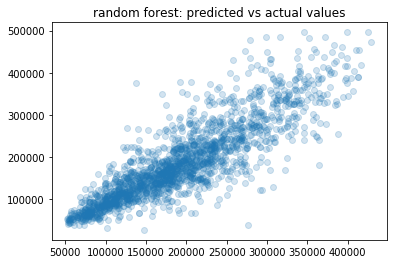

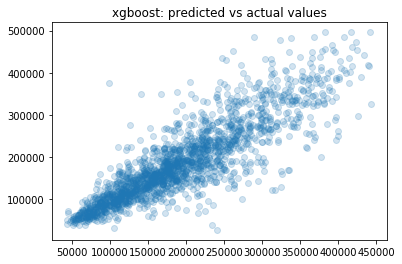

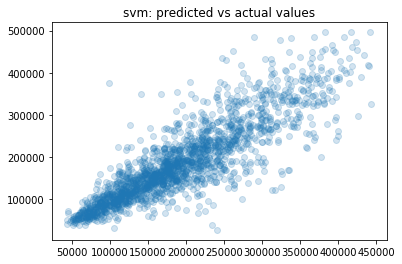

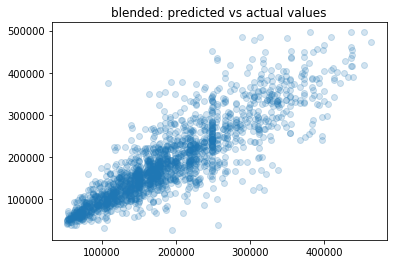

In [15]:
# 10. plot models to see how they fit over the range

def plt_model(X_train, y_train, model, model_names, **kwargs):
    for i, m in enumerate(models):
        y_predict = m.predict(X_train)
        plt.scatter(x=y_predict, y=y_train, **kwargs)
        plt.title(model_names[i]+": "+"predicted vs actual values")
        plt.show()
    
plt_model(X_t1, y_t1, models, model_names, alpha=0.2)

## Model Selection - Final Comments

Although the blended model has the highest R2 and lowest RMSE (suggesting it is the best model fit), a plot of actual versus predicted values shows strange segmentation patterns in the blended model. This awkward fit suggests it is overfitting in areas and therefore its high metrics should be taken with caution. 

The other models perform almost as well but show much more smoothness in their prediction. There is little reason to prefer one model over the other, but for the time being, one can select Random Forest as it happens to be performing slightly better on this instance of test data than the other models.

An interative process of modeling tuning on the first level and blended models could likely produce an even more regularized/optimal fit for the data. For the purpose of this exercise, it is probably not worth it, since the gains are likely to be modest. Feature engineering would likely be the next best area to go to in order to try to further improve model performance.

In [16]:
# 11. get final model selection fit statistics

# estimate of generalizability
compare_models(X_t2, y_t2, [rf_model], ["random forest"]).style.hide_index()

model,r2,rmse
random forest,0.7297,50333


In [134]:
# 12. build final model pipeline to get predictions from data

# get list of categories that X was trained on in 'ocean proximity'
cat_list  = X_train['ocean_proximity'].value_counts().index

# define a label binarizer to work with pipeline and keep low category counts
# note: this is a departure of earlier model building which discarded low category counts (i.e. "ISLAND")
#       also, instead of going to the trouble of making another sklearn.pipeline.Pipeline compatible
#       class, I'm just going to write some functions that do the same kind of thing
def binarize_selected_categories(data, feature, selected_cat):
    # get data without selected feature to binarize
    labels            = data.columns
    labels_wo_feature = labels.difference(np.array([feature]))
    df1 = data[labels_wo_feature]
    
    # binarize columns, fix labels
    df2 = pd.get_dummies(data[feature], prefix="")
    _labels = df2.columns
    labels = [j[1:] for j in _labels]
    df2.columns = labels
    
    # subset to only include categories of interest
    df2 = df2[selected_cat]
    
    # merge data and return
    return(pd.concat([df1, df2], axis=1))

# define final transformation pipeline by category type
cat_pipeline_f = Pipeline((
    ("selector", DataFrameSelector(cat_list)),
))

# define final transformation pipeline
t_pipeline_f = FeatureUnion(transformer_list=[
    ("cat_pipeline",  cat_pipeline_f),
    ("cont_pipeline", cont_pipeline),
    ("log_pipeline",  log_pipeline)
])

# final pipeline to get predictions from original data object
# this is the function you run on the newly imported data to get predictions from the final selected model
def get_predictions(data):
    X, y = split_data(data)
    X    = binarize_selected_categories(X, "ocean_proximity", cat_list)
    X_t  = t_pipeline_f.fit_transform(X)
    p    = rf_model.predict(X_t)
    return(p)

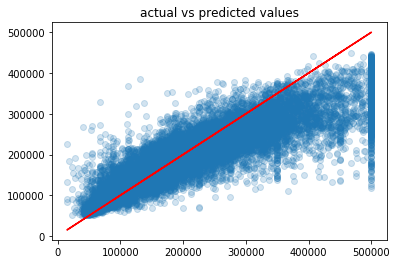

In [135]:
# 13. test final pipeline

# get actual y-values and predicted y-values
X, y_actual = split_data(data)
y_predict   = get_predictions(data)

# just a plot of the predicted value to show pipeline is working
plt.scatter(x=y_actual, y=y_predict, alpha=0.2)
plt.plot(y_actual, y_actual, c="red")
plt.title("actual vs predicted values")
plt.show()

## Final Comments

The final pipeline `get_predictions` accepts housing data as an argument and returns predictions based on the final selected model, the random forest model. Originally, the model was built by removing capped observations and low category counts in `ocean_proximity`. However, note that the final pipeline returns predictions on arbitrary data without cleaning. 

This appears to not product an optimal fit. The model appears to skew when including observations whose values had been capped ('median_house_value', 'housing_median_age'). However, this model-based approach probably has more validity in a real-world setting where capped observations do not exist. It will be up to the operator to determine if capped observations should be used. If so, they should make proper adjustments by retraining the model with capped observations.